<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b> I tried BERTopic model [1,2] for zero-shot topic modelling. I used <b>35 topics</b> for modelling.</span></i>


* I applied several <b>preprocessing</b> operations (cleaning, dropping stop words, lemmatization),
* A function for creating candidate topics (unique Disease Name),
* I used <b>a DeBERTa based model </b> for the zero-hot classification [3],


<i>TODO: calculate topics coherence for evaluate the model.</i>


## Results

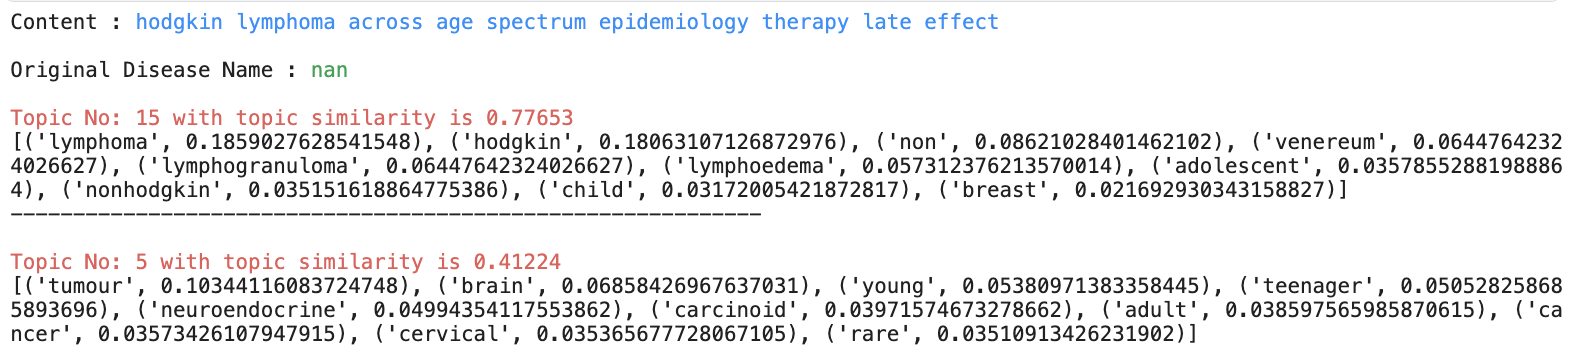

<br>

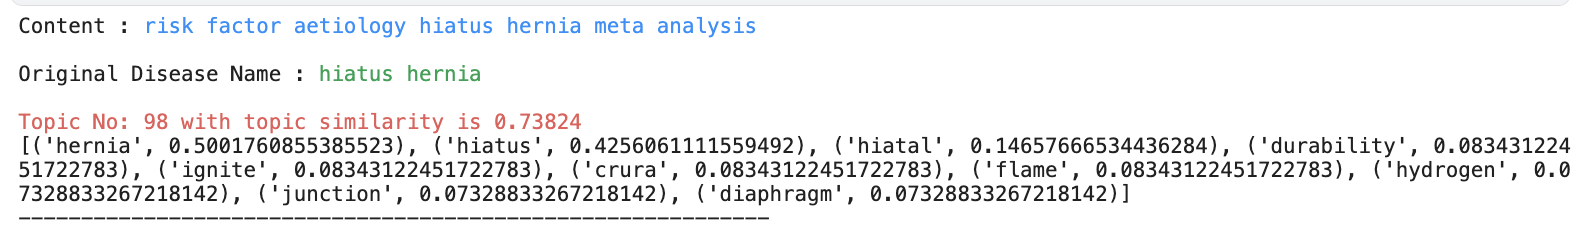


## My Another Projects
* [Spam vs Ham Message w/ Gemma 7B Fine-Tuning (LoRA)](https://www.kaggle.com/code/banddaniel/spam-vs-ham-message-w-gemma-7b-fine-tuning-lora)
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)
* [Towards Data Science Articles Topic Modeling w/LDA](https://www.kaggle.com/code/banddaniel/towards-data-science-articles-topic-modeling-w-lda)


## References
1. Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2203.05794
2. https://maartengr.github.io/BERTopic/getting_started/zeroshot/zeroshot.html
3. https://huggingface.co/MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli

In [1]:
from IPython.display import clear_output
!pip install bertopic
clear_output()

In [2]:
# Importing dependencies

import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import  stopwords
import string
import spacy
import pprint
from colorama import Fore, Back, Style

from bertopic import BERTopic
from bertopic.representation import ZeroShotClassification
from comm import create_comm

2024-03-25 13:52:41.502653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 13:52:41.502760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 13:52:41.641863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
raw_data = pd.read_csv('/kaggle/input/diseases-articles/diseases_articles.csv')
raw_data = raw_data.drop_duplicates(subset = ['Sentence'])

# shuffling and dropping several columns
raw_data.drop(['Unnamed: 0','Spacy Tokens Target','BERT Tokens Target'], axis = 1, inplace = True)
raw_data = raw_data.sample(frac = 1).reset_index(drop= True)
raw_data.head()

,Disease Name,Sentence
0,germ cell tumours,Gonadal and extragonadal germ cell tumours in ...
1,laryngitis,Correlation of pH probe–measured laryngopharyn...
2,gout,The global burden of gout: estimates from the ...
3,mumps,Mumps
4,NaN,Measures to Control and Prevent Clostridium di...


# <span style="color:#e74c3c;"> Preprocessing </span>

In [4]:
%%time
# preprocessing functions

stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\[.*?\]', ' ', text)
    text = re.sub(r'\\W',' ',text) 
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', ' ', text)    
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text

def lemmatization(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)    
    return lemmatized_text

def delete_one_characters(text):
    deleted = [word if len(word)>1 else " " for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text

# applying preprocessing functions
data = raw_data.copy()
data['preprocessed_Sentence'] = data['Sentence'].apply(text_preprocessing).apply(drop_stopwords).apply(lemmatization).apply(delete_one_characters)
data['preprocessed_Disease_Name'] = data['Disease Name'].apply(text_preprocessing).apply(drop_stopwords).apply(lemmatization).apply(delete_one_characters)

CPU times: user 48.2 s, sys: 40.5 ms, total: 48.3 s
Wall time: 48.3 s


# <span style="color:#e74c3c;"> Create </span> Candidate Topics

In [5]:
# creating unique Disease names as candidate topics for zero-shot classification
# using top 30 values in the data frame

candidate_topics = data['preprocessed_Disease_Name'].value_counts()[:30].keys().tolist()

print('candidate unique topics numbers :\t', len(candidate_topics))
print('topics examples :\t', candidate_topics[-5:])

candidate unique topics numbers :	 30
topics examples :	 ['erectile dysfunction', 'gastroenteritis', 'heart attack', 'rosacea', 'congenital heart disease']


In [6]:
data.head()

,Disease Name,Sentence,preprocessed_Sentence,preprocessed_Disease_Name
0,germ cell tumours,Gonadal and extragonadal germ cell tumours in ...,gonadal extragonadal germ cell tumours united ...,germ cell tumour
1,laryngitis,Correlation of pH probe–measured laryngopharyn...,correlation ph probe measure laryngopharynge...,laryngitis
2,gout,The global burden of gout: estimates from the ...,global burden gout estimate global burden dise...,gout
3,mumps,Mumps,mump,mump
4,NaN,Measures to Control and Prevent Clostridium di...,measure control prevent clostridium difficile ...,nan


# <span style="color:#e74c3c;"> BERTopic </span> Model

In [7]:
representation_model = ZeroShotClassification(candidate_topics, model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")

topic_model = BERTopic(nr_topics = len(candidate_topics) + 5, zeroshot_min_similarity = 0.7, representation_model=representation_model, verbose=True)

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

# <span style="color:#e74c3c;"> Training </span>

In [8]:
%%time
topics, probs = topic_model.fit_transform(data['preprocessed_Sentence'].values)

2024-03-25 13:53:48,597 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/147 [00:00<?, ?it/s]

2024-03-25 13:53:54,475 - BERTopic - Embedding - Completed ✓
2024-03-25 13:53:54,476 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-25 13:54:21,937 - BERTopic - Dimensionality - Completed ✓
2024-03-25 13:54:21,939 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-25 13:54:22,224 - BERTopic - Cluster - Completed ✓
2024-03-25 13:54:22,225 - BERTopic - Representation - Extracting topics from clusters using representation models.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
2024-03-25 14:08:37,133 - BERTopic - Representation - Completed ✓
2024-03-25 14:08:37,134 - BERTopic - Topic reduction - Reducing number of topics
2024-03-25 14:11:30,592 - BERTopic - Topic reduction - Reduced number of topics from 173 to 35


CPU times: user 34min 52s, sys: 8.53 s, total: 35min 1s
Wall time: 17min 42s


# <span style="color:#e74c3c;"> Topic </span> Results

In [9]:
# topic no -1 for the outlier topic
# count -> clustering samples

freq = topic_model.get_topic_info()
freq.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,888,-1_review_treatment_risk_cough,"[review, treatment, risk, cough, cancer, disor...","[pathogenesis treatment sickle cell disease, u..."
1,0,314,0_leukaemia_young_lymphoma_tumour,"[leukaemia, young, lymphoma, tumour, hodgkin, ...",[acute lymphoblastic leukemia adolescent young...
2,1,298,1_angina___,"[angina, , , , , , , , , ]","[heart hypertension, epidemiology heart failur..."
3,2,250,2_chickenpox___,"[chickenpox, , , , , , , , , ]","[genital herpe review, psychological symptom a..."
4,3,214,3_prostate_testicular_pelvic_ovarian,"[prostate, testicular, pelvic, ovarian, prosta...",[pelvic organ prolapse old woman prevalence ri...


In [10]:
# visualizing top 10 topics
topic_model.visualize_barchart(top_n_topics=10, height=200)

# <span style="color:#e74c3c;"> Intertopic Distance </span> Map

In [11]:
topic_model.visualize_topics()

# <span style="color:#e74c3c;"> Topic Similarity </span> Maxrix

In [12]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=15)

# <span style="color:#e74c3c;"> Test Topic Modelling</span> Pipeline

In [13]:
def create_end2end_topic_prediction(topic_model, df, similarity_threshold:float, top_n_topic:int) -> None:
    """
    @topic_model : BERTopic model
    @df : raw dataframe
    @similarity_threshold : topic similarity threshold
    @top_n_topic : top n topic 
    
    """

    raw_df = df.sample(1)
    raw_df['preprocessed_Sentence'] = raw_df['Sentence'].apply(text_preprocessing).apply(drop_stopwords).apply(lemmatization).apply(delete_one_characters)
    preprocessed_text = raw_df['preprocessed_Sentence'].values[0] 
    
    print('Content : '+Fore.BLUE + preprocessed_text + Style.RESET_ALL)
    print('\nOriginal Disease Name : '+Fore.GREEN + str(raw_df['Disease Name'].values[0]) + Style.RESET_ALL)
    
    #calculating topics and similarities
    similar_topics, similarity = topic_model.find_topics(preprocessed_text, top_n=top_n_topic)
    
    #printing topics
    for i in range(top_n_topic):
        if (similarity[i] >= similarity_threshold) & (similar_topics[i] != -1):
            print(Fore.RED + '\nTopic No: {0} with topic similarity is {1:.5f}'.format(similar_topics[i], similarity[i]) + Style.RESET_ALL)
            print(topic_model.get_topic(similar_topics[i]))
            print("--"*30)

In [14]:
# random topic prediction
create_end2end_topic_prediction(topic_model, raw_data, 0.4, 2)

Content : epidemiology panic attack panic disorder result three community survey

Original Disease Name : panic panic disorder

Topic No: 7 with topic similarity is 0.47408
[('disorder', 0.1156917688880193), ('anxiety', 0.08150966200681949), ('nervosa', 0.06910993953295703), ('stress', 0.06085147459046214), ('anorexia', 0.05194956734864643), ('eat', 0.05194956734864643), ('psychosis', 0.04659469828782142), ('bulimia', 0.04659469828782142), ('binge', 0.04382343674695182), ('mood', 0.04225871304103813)]
------------------------------------------------------------


In [15]:
# random topic prediction
create_end2end_topic_prediction(topic_model, raw_data, 0.4, 2)

Content : work memory

Original Disease Name : nan


In [16]:
# random topic prediction
create_end2end_topic_prediction(topic_model, raw_data, 0.3, 2)

Content : common various cause dizziness critical review

Original Disease Name : dizziness

Topic No: 13 with topic similarity is 0.45789
[('ear', 0.13535376319244594), ('meniere', 0.07847576044235237), ('loss', 0.06858642917612869), ('hear', 0.0676376055727339), ('middle', 0.06488634989249097), ('dizziness', 0.06305374582626937), ('labyrinthitis', 0.058966205511644436), ('otitis', 0.058966205511644436), ('deafblindness', 0.05476905808211759), ('hearing', 0.049292152273905834)]
------------------------------------------------------------

Topic No: 5 with topic similarity is 0.32686
[('headache', 0.8543133735656738), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)]
------------------------------------------------------------


In [17]:
# random topic prediction
create_end2end_topic_prediction(topic_model, raw_data, 0.3, 2)

Content : dysphagia intensive care unit epidemiology mechanism clinical management

Original Disease Name : nan

Topic No: 5 with topic similarity is 0.47508
[('headache', 0.8543133735656738), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)]
------------------------------------------------------------

Topic No: 12 with topic similarity is 0.40937
[('mouth', 0.105069175257066), ('cold', 0.10276981876824294), ('sore', 0.08926890819154484), ('dental', 0.05786957879972751), ('abscess', 0.05212725645698016), ('throat', 0.05134969060121278), ('gum', 0.0510199574961715), ('laryngitis', 0.04801750019079868), ('common', 0.04784926142840181), ('laryngeal', 0.04377954408284467)]
------------------------------------------------------------
